In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
#         break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os, random, math, json, time, itertools, glob, shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset, SubsetRandomSampler
import torchvision
from torchvision.datasets import VOCDetection
from torchvision.ops import box_iou
from torchvision.transforms import functional as TF
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tqdm.auto import tqdm
torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(42); np.random.seed(42); torch.manual_seed(42)


In [3]:
KAGGLE_VOC12 = "/kaggle/input/pascal-voc-2012"
SRC_VOC12 = os.path.join(KAGGLE_VOC12, "VOC2012") if os.path.isdir(os.path.join(KAGGLE_VOC12, "VOC2012")) else KAGGLE_VOC12
VOC_ROOT = "./vocdata"
DEST_VOC12 = os.path.join(VOC_ROOT, "VOCdevkit", "VOC2012")
os.makedirs(DEST_VOC12, exist_ok=True)
for name in ["Annotations","ImageSets","JPEGImages","SegmentationClass","SegmentationObject"]:
    src = os.path.join(SRC_VOC12, name)
    dst = os.path.join(DEST_VOC12, name)
    if os.path.exists(src) and not os.path.exists(dst):
        try: os.symlink(src, dst)
        except Exception: shutil.copytree(src, dst, dirs_exist_ok=True)
print({"src": SRC_VOC12, "dest": DEST_VOC12, "ok": os.path.isdir(os.path.join(DEST_VOC12,"JPEGImages"))})


{'src': '/kaggle/input/pascal-voc-2012/VOC2012', 'dest': './vocdata/VOCdevkit/VOC2012', 'ok': True}


In [4]:
classes = ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
cls2id = {c:i+1 for i,c in enumerate(classes)}
id2cls = {i+1:c for i,c in enumerate(classes)}

def parse_voc_target(t):
    a = t['annotation']
    w = int(a['size']['width']); h = int(a['size']['height'])
    objs = a.get('object', [])
    if isinstance(objs, dict): objs = [objs]
    boxes = []; labels = []
    for o in objs:
        b = o['bndbox']
        x1 = max(0, float(b['xmin'])-1); y1 = max(0, float(b['ymin'])-1)
        x2 = min(w-1, float(b['xmax'])-1); y2 = min(h-1, float(b['ymax'])-1)
        if x2<=x1 or y2<=y1: continue
        boxes.append([x1,y1,x2,y2])
        labels.append(cls2id[o['name']])
    boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0,4),dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,),dtype=torch.int64)
    return boxes, labels, w, h


In [5]:
class Compose:
    def __init__(self, ops): self.ops = ops
    def __call__(self, img, target):
        for o in self.ops: img, target = o(img, target)
        return img, target

class RandomHFlip:
    def __init__(self, p=0.5): self.p = p
    def __call__(self, img, target):
        if random.random()<self.p:
            w = img.size[0] if isinstance(img, Image.Image) else img.shape[2]
            if isinstance(img, Image.Image): img = TF.hflip(img)
            else: img = torch.flip(img, dims=[2])
            boxes = target['boxes'].clone()
            if boxes.numel()>0:
                boxes[:,[0,2]] = (w-1) - boxes[:,[2,0]]
            target['boxes'] = boxes
        return img, target

class ResizeJitter:
    def __init__(self, min_size=320, max_size=640):
        self.min_size=min_size; self.max_size=max_size
    def __call__(self, img, target):
        if isinstance(img, Image.Image):
            w0,h0 = img.size
        else:
            _,h0,w0 = img.shape
            img = TF.to_pil_image(img)
        size = random.randint(self.min_size, self.max_size)
        scale = size/min(h0,w0)
        nw,nh = int(round(w0*scale)), int(round(h0*scale))
        img2 = TF.resize(img, (nh,nw))
        boxes = target['boxes']
        if boxes.numel()>0:
            s = torch.tensor([scale,scale,scale,scale])
            boxes = boxes*s
        target['boxes'] = boxes
        target['orig_size'] = torch.tensor([nh,nw])
        return TF.to_tensor(img2), target

class FixedResize:
    def __init__(self, size=512): self.size=size
    def __call__(self, img, target):
        if isinstance(img, Image.Image): w0,h0 = img.size
        else:
            _,h0,w0 = img.shape
            img = TF.to_pil_image(img)
        scale = self.size/min(h0,w0)
        nw,nh = int(round(w0*scale)), int(round(h0*scale))
        img2 = TF.resize(img, (nh,nw))
        boxes = target['boxes']
        if boxes.numel()>0:
            s = torch.tensor([scale,scale,scale,scale])
            boxes = boxes*s
        target['boxes'] = boxes
        target['orig_size'] = torch.tensor([nh,nw])
        return TF.to_tensor(img2), target


In [6]:
class VOCDataset(Dataset):
    def __init__(self, root, year, image_set, transforms=None):
        self.ds = VOCDetection(root=root, year=year, image_set=image_set, download=False)
        self.transforms = transforms
    def __len__(self): return len(self.ds)
    def __getitem__(self, idx):
        img, t = self.ds[idx]
        boxes, labels, w, h = parse_voc_target(t)
        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx]), 'orig_size': torch.tensor([h,w])}
        if self.transforms: img, target = self.transforms(img, target)
        return img, target


In [7]:
train_tf = Compose([RandomHFlip(0.5), ResizeJitter(320,640)])
val_tf   = Compose([FixedResize(512)])

voc12_train = VOCDataset(VOC_ROOT, '2012', 'train', transforms=train_tf)
voc12_val   = VOCDataset(VOC_ROOT, '2012', 'val', transforms=val_tf)

train_ds = voc12_train
val_ds   = voc12_val

def collate_fn(batch):
    imgs, targets = list(zip(*batch))
    return list(imgs), list(targets)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn, pin_memory=True)

print({'root': VOC_ROOT, 'train_images': len(train_ds), 'val_images': len(val_ds)})


{'root': './vocdata', 'train_images': 5717, 'val_images': 5823}


In [8]:
frac = 0.05
seed = 42
n_train = len(train_ds)
n_sub = max(1, int(math.ceil(frac * n_train)))
rng = np.random.default_rng(seed)
train_indices = np.sort(rng.choice(n_train, size=n_sub, replace=False)).tolist()
train_loader = DataLoader(
    train_ds,
    batch_size=4,
    sampler=SubsetRandomSampler(train_indices),
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True,
)
n_val = len(val_ds)
n_sub = max(1, int(math.ceil(frac * n_val)))
rng = np.random.default_rng(seed)
val_indices = np.sort(rng.choice(n_val, size=n_sub, replace=False)).tolist()
val_loader = DataLoader(
    val_ds,
    batch_size=4,
    sampler=SubsetRandomSampler(val_indices),
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True,
)
print({'val_subset': len(val_indices), 'val_total': n_train})


{'val_subset': 292, 'val_total': 5717}


  0%|          | 0/286 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

{'train_subset_images': 286, 'val_images': 5823, 'train_boxes': 875, 'val_boxes': 8278, 'avg_boxes_per_train_image': 3.0594405594405596, 'avg_boxes_per_val_image': 2.759333333333333}


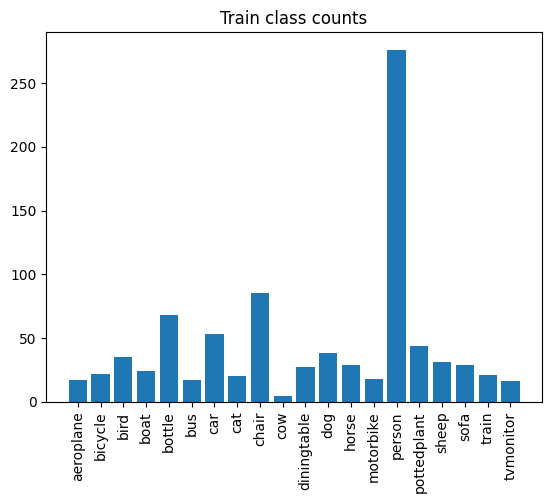

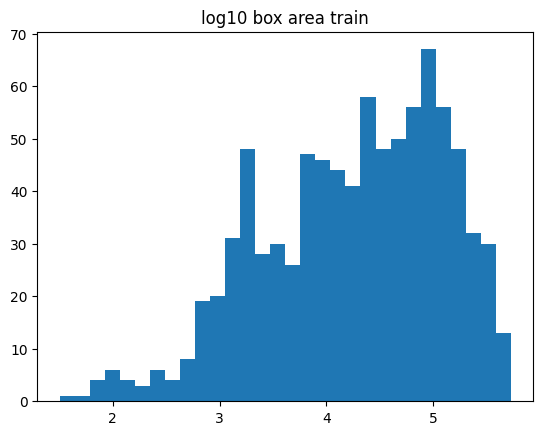

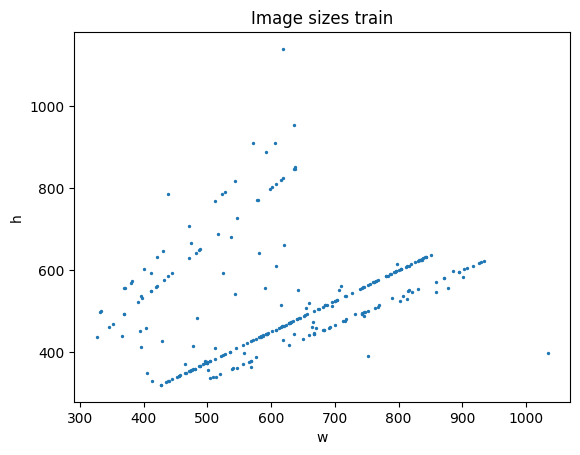

In [9]:
def gather_stats_full(ds, max_items=6000):
    n = min(len(ds), max_items)
    per_class = Counter()
    areas = []
    img_sizes = []
    boxes_per_img = []
    aspect = []
    for i in tqdm(range(n)):
        img,t = ds[i] if not isinstance(ds, Subset) else ds.dataset[ds.indices[i]]
        if isinstance(ds, Subset):
            _,t = ds[i]
        boxes = t['boxes']; labels = t['labels']
        h,w = t['orig_size'].tolist()
        img_sizes.append((w,h))
        boxes_per_img.append(len(labels))
        for l in labels.tolist(): per_class[l]+=1
        if boxes.numel()>0:
            wh = torch.stack([(boxes[:,2]-boxes[:,0]), (boxes[:,3]-boxes[:,1])], dim=1)
            a = (wh[:,0]*wh[:,1]).tolist()
            areas.extend(a)
            asp = (wh[:,0]/(wh[:,1]+1e-6)).abs().tolist()
            aspect.extend(asp)
    return per_class, np.array(areas), np.array(img_sizes), np.array(boxes_per_img), np.array(aspect)

from torch.utils.data import Subset
sample_for_eda = Subset(train_ds, train_indices)
train_cls, train_areas, train_sizes, train_bpi, train_aspect = gather_stats_full(sample_for_eda, 3000)
val_cls, val_areas, val_sizes, val_bpi, val_aspect = gather_stats_full(val_ds, 3000)
print({
    'train_subset_images': len(sample_for_eda),
    'val_images': len(val_ds),
    'train_boxes': int(sum(train_cls.values())),
    'val_boxes': int(sum(val_cls.values())),
    'avg_boxes_per_train_image': float(train_bpi.mean()) if len(train_bpi)>0 else 0.0,
    'avg_boxes_per_val_image': float(val_bpi.mean()) if len(val_bpi)>0 else 0.0
})
plt.figure(); plt.bar([id2cls[k] for k in sorted(train_cls.keys())],[train_cls[k] for k in sorted(train_cls.keys())]); plt.xticks(rotation=90); plt.title('Train class counts'); plt.show()
plt.figure(); plt.hist(np.log10(train_areas+1e-6), bins=30); plt.title('log10 box area train'); plt.show()
plt.figure(); plt.scatter(train_sizes[:,0], train_sizes[:,1], s=2); plt.xlabel('w'); plt.ylabel('h'); plt.title('Image sizes train'); plt.show()


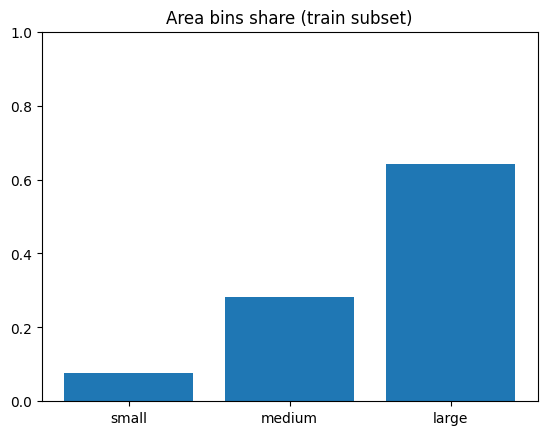

In [10]:
def coco_area_bins():
    return {'small': (0, 32*32), 'medium': (32*32, 96*96), 'large': (96*96, float('inf'))}

bins = coco_area_bins()
small_pct = (train_areas < bins['small'][1]).mean() if len(train_areas)>0 else 0
med_pct = ((train_areas >= bins['medium'][0]) & (train_areas < bins['medium'][1])).mean() if len(train_areas)>0 else 0
large_pct = (train_areas >= bins['large'][0]).mean() if len(train_areas)>0 else 0
plt.figure(); plt.bar(['small','medium','large'], [small_pct, med_pct, large_pct]); plt.ylim(0,1); plt.title('Area bins share (train subset)'); plt.show()


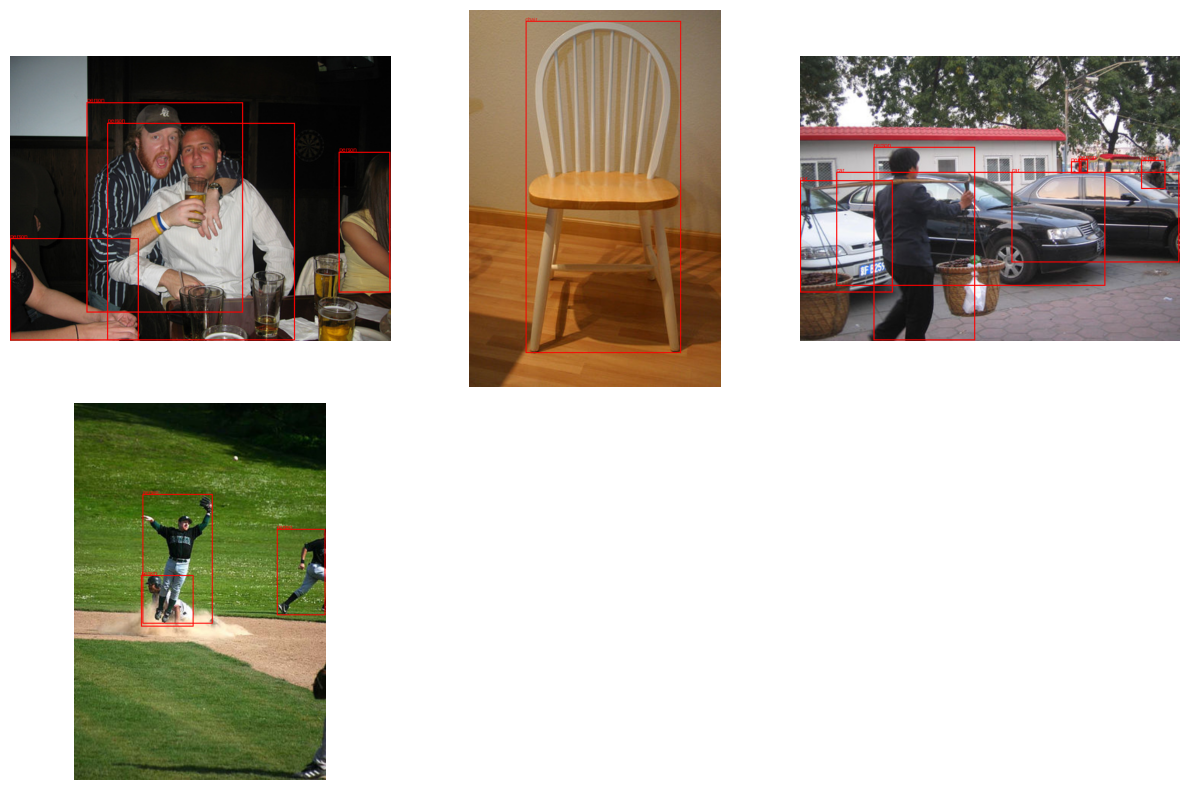

In [11]:
def draw_boxes(img_t, boxes, labels=None, scores=None, maxn=30):
    img = TF.to_pil_image(img_t.cpu())
    draw = ImageDraw.Draw(img)
    for i,(x1,y1,x2,y2) in enumerate(boxes[:maxn]):
        draw.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=2)
        if labels is not None:
            txt = id2cls[int(labels[i])]
            if scores is not None: txt += f' {scores[i]:.2f}'
            draw.text((x1, max(0,y1-10)), txt, fill=(255,0,0))
    return img

bimgs, btgts = next(iter(val_loader))
fig = plt.figure(figsize=(12,8))
for i in range(min(6,len(bimgs))):
    ax = plt.subplot(2,3,i+1)
    b = btgts[i]['boxes'].cpu().numpy() if btgts[i]['boxes'].numel()>0 else np.zeros((0,4))
    l = btgts[i]['labels'].cpu().numpy() if btgts[i]['labels'].numel()>0 else np.zeros((0,))
    img = draw_boxes(bimgs[i], b, l, None)
    ax.imshow(img); ax.axis('off')
plt.tight_layout(); plt.show()


In [12]:
def voc_ap(rec, prec):
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))
    for i in range(mpre.size-1,0,-1): mpre[i-1] = np.maximum(mpre[i-1], mpre[i])
    i = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[i+1]-mrec[i]) * mpre[i+1])
    return ap

def evaluate_predictions(gt, preds, iou_thresh=0.5, area_rng=None):
    aps = {}
    for cid in range(1,21):
        gt_by_img = {}
        npos = 0
        for img_id, g in gt.items():
            mask = (g['labels']==cid)
            if area_rng is not None:
                a = (g['boxes'][:,2]-g['boxes'][:,0])*(g['boxes'][:,3]-g['boxes'][:,1])
                mask = mask & (a>=area_rng[0]) & (a<area_rng[1])
            boxes = g['boxes'][mask]
            gt_by_img[img_id] = {'boxes': boxes, 'det': np.zeros(len(boxes))}
            npos += len(boxes)
        if npos==0:
            aps[cid] = np.nan
            continue
        pred_list = []
        for img_id, p in preds.items():
            if len(p['boxes'])==0: continue
            m = (p['labels']==cid)
            b = p['boxes'][m]
            s = p['scores'][m]
            for j in range(len(b)):
                pred_list.append((img_id, s[j], b[j]))
        if len(pred_list)==0:
            aps[cid] = 0.0
            continue
        pred_list.sort(key=lambda x: float(x[1]), reverse=True)
        tp = np.zeros(len(pred_list)); fp = np.zeros(len(pred_list))
        for i,(img_id, score, bb) in enumerate(pred_list):
            g = gt_by_img.get(img_id, {'boxes': torch.empty((0,4)), 'det': np.array([])})
            BBGT = g['boxes']
            if BBGT.numel()>0:
                ious = box_iou(bb.unsqueeze(0), BBGT).squeeze(0).numpy()
                j = np.argmax(ious) if ious.size>0 else -1
                ovmax = ious[j] if ious.size>0 else 0
            else:
                ovmax = 0; j = -1
            if ovmax>iou_thresh and j>-1 and g['det'][j]==0:
                tp[i]=1; g['det'][j]=1
            else:
                fp[i]=1
            gt_by_img[img_id]=g
        fp = np.cumsum(fp); tp = np.cumsum(tp)
        rec = tp/float(npos); prec = tp/np.maximum(tp+fp, np.finfo(np.float64).eps)
        aps[cid] = voc_ap(rec, prec)
    valid = [v for v in aps.values() if not np.isnan(v)]
    mAP = np.mean(valid) if len(valid)>0 else 0.0
    return aps, mAP


In [13]:
def collect_gts(dataloader):
    gts = {}
    for imgs, targets in dataloader:
        for i in range(len(imgs)):
            img_id = int(targets[i]['image_id'])
            gts[img_id] = {'boxes': targets[i]['boxes'].to('cpu'), 'labels': targets[i]['labels'].to('cpu')}
    return gts

@torch.inference_mode()
def predict_model(model, dataloader, score_thr=0.001):
    model.eval()
    preds = {}
    for imgs, targets in tqdm(dataloader, leave=False):
        imgs = [im.to(device) for im in imgs]
        outputs = model(imgs)
        for out, tgt in zip(outputs, targets):
            img_id = int(tgt['image_id'])
            b = out['boxes'].to('cpu'); s = out['scores'].to('cpu'); l = out['labels'].to('cpu')
            m = s>=score_thr
            preds[img_id] = {'boxes': b[m], 'scores': s[m], 'labels': l[m]}
    return preds

def coco_area_bins():
    return {'small':(0, 32*32), 'medium':(32*32, 96*96), 'large':(96*96, 1e12)}


In [14]:
def make_fasterrcnn_no_fpn(num_classes=21):
    try:
        backbone_full = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
    except:
        backbone_full = torchvision.models.resnet50(weights=None)
    modules = list(backbone_full.children())[:-2]
    backbone = nn.Sequential(*modules)
    backbone.out_channels = 2048
    anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((32,64,128,256,512),), aspect_ratios=((0.5,1.0,2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
    model = torchvision.models.detection.FasterRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
    return model

def make_fasterrcnn_fpn(num_classes=21):
    try:
        m = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    except:
        m = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
    in_features = m.roi_heads.box_predictor.cls_score.in_features
    m.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return m

def make_retinanet(num_classes=21):
    try:
        m = torchvision.models.detection.retinanet_resnet50_fpn(weights='DEFAULT')
    except:
        m = torchvision.models.detection.retinanet_resnet50_fpn(weights=None, weights_backbone=None)
    m.head.classification_head.num_classes = num_classes - 1
    m.head.classification_head.cls_logits = nn.Conv2d(
        m.head.classification_head.conv[0].out_channels,
        m.head.classification_head.num_anchors*(num_classes-1),
        kernel_size=3, stride=1, padding=1
    )
    torch.nn.init.constant_(m.head.classification_head.cls_logits.bias, -math.log((1-0.01)/0.01))
    return m


In [15]:
def _check_label_ranges(ds, max_check=2000, num_classes_no_bg=20):
    bad = 0
    for i in range(min(len(ds), max_check)):
        _, t = ds[i]
        if t['labels'].numel():
            if (t['labels'] < 1).any() or (t['labels'] > num_classes_no_bg).any():
                bad += 1; break
    print({'labels_ok': bad==0})

# _check_label_ranges(train_ds)


In [16]:
import contextlib

def train_one_epoch(model, loader, optimizer, scaler, epoch, max_norm=10.0):
    model.train()
    losses_hist = []
    it_losses = []
    pbar = tqdm(loader, leave=False)
    for imgs, targets in pbar:
        imgs = [im.to(device) for im in imgs]
        tgts = [{k: v.to(device) for k, v in t.items() if k in ['boxes','labels']} for t in targets]
        cm = torch.amp.autocast('cuda') if device.type == 'cuda' else contextlib.nullcontext()
        with cm:
            loss_dict = model(imgs, tgts)
            loss = sum(loss_dict.values())
        optimizer.zero_grad(set_to_none=True)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()
        l = float(loss.detach().item())
        losses_hist.append(l); it_losses.append(l)
        if len(it_losses) > 50: it_losses.pop(0)
        pbar.set_description(f"e{epoch} loss {np.mean(it_losses):.3f}")
    return float(np.mean(losses_hist)), losses_hist

def fit_with_eval(model, train_loader, val_loader, epochs=5, lr=0.005):
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
    lr_s = optim.lr_scheduler.StepLR(optimizer, step_size=max(epochs//2,1), gamma=0.1)
    scaler = torch.amp.GradScaler('cuda') if device.type == 'cuda' else None
    loss_hist = []; iter_hist = []
    map_hist = []; map_s_hist = []; map_m_hist = []; map_l_hist = []
    gts = collect_gts(val_loader)
    for e in range(1, epochs+1):
        l_avg, l_iter = train_one_epoch(model, train_loader, optimizer, scaler, e)
        lr_s.step()
        loss_hist.append(l_avg)
        iter_hist.extend([(e-1)+i/len(train_loader) for i in range(len(l_iter))])
        preds = predict_model(model, val_loader, 0.001)
        _, mAP = evaluate_predictions(gts, preds, 0.5, None)
        _, mAPs = evaluate_predictions(gts, preds, 0.5, coco_area_bins()['small'])
        _, mAPm = evaluate_predictions(gts, preds, 0.5, coco_area_bins()['medium'])
        _, mAPl = evaluate_predictions(gts, preds, 0.5, coco_area_bins()['large'])
        map_hist.append(mAP); map_s_hist.append(mAPs); map_m_hist.append(mAPm); map_l_hist.append(mAPl)
    preds = predict_model(model, val_loader, 0.001)
    aps, mAP = evaluate_predictions(gts, preds, 0.5, None)
    _, mAP_s = evaluate_predictions(gts, preds, 0.5, coco_area_bins()['small'])
    _, mAP_m = evaluate_predictions(gts, preds, 0.5, coco_area_bins()['medium'])
    _, mAP_l = evaluate_predictions(gts, preds, 0.5, coco_area_bins()['large'])
    return {'loss_hist':loss_hist,'iter_hist':iter_hist,'map_hist':map_hist,'map_s_hist':map_s_hist,'map_m_hist':map_m_hist,'map_l_hist':map_l_hist,'aps':aps,'mAP':mAP,'mAP_small':mAP_s,'mAP_medium':mAP_m,'mAP_large':mAP_l,'preds':preds}


In [17]:
epochs = 2

model_nofpn = make_fasterrcnn_no_fpn(21)
res_nofpn = fit_with_eval(model_nofpn, train_loader, val_loader, epochs=epochs, lr=0.005)
print(json.dumps({'mAP':res_nofpn['mAP'],'mAP_small':res_nofpn['mAP_small'],'mAP_medium':res_nofpn['mAP_medium'],'mAP_large':res_nofpn['mAP_large']}, indent=2))


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

{
  "mAP": 0.00023474178403755868,
  "mAP_small": 0.0,
  "mAP_medium": 0.0,
  "mAP_large": 0.0003225806451612903
}


In [18]:
model_fpn = make_fasterrcnn_fpn(21)
res_fpn = fit_with_eval(model_fpn, train_loader, val_loader, epochs=epochs, lr=0.005)
print(json.dumps({'mAP':res_fpn['mAP'],'mAP_small':res_fpn['mAP_small'],'mAP_medium':res_fpn['mAP_medium'],'mAP_large':res_fpn['mAP_large']}, indent=2))


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 209MB/s] 


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/73 [00:10<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

{
  "mAP": 0.2925865503149404,
  "mAP_small": 0.005266451971393597,
  "mAP_medium": 0.11257572086735503,
  "mAP_large": 0.2770585833684396
}


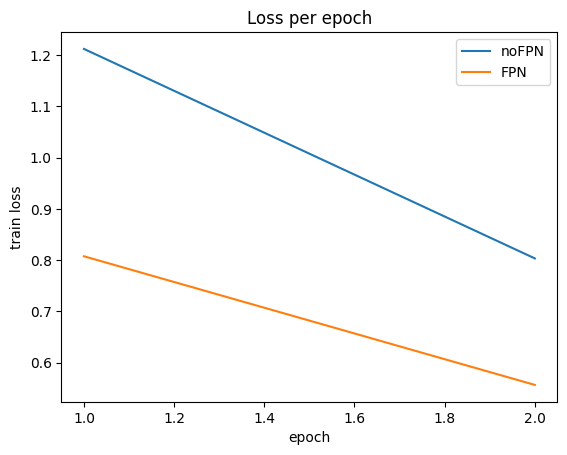

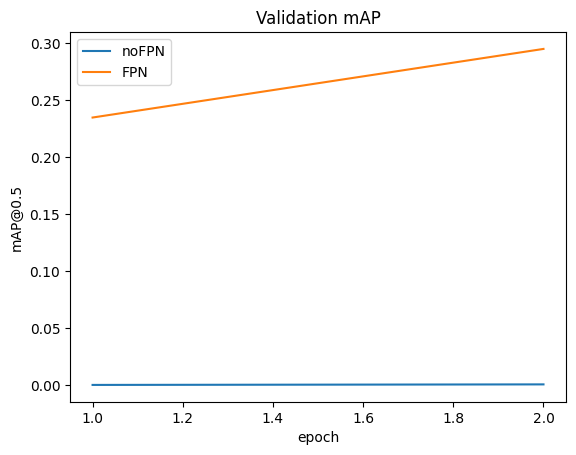

In [19]:
plt.figure(); plt.plot(range(1,epochs+1), res_nofpn['loss_hist'], label='noFPN')
plt.plot(range(1,epochs+1), res_fpn['loss_hist'], label='FPN')
plt.xlabel('epoch'); plt.ylabel('train loss'); plt.title('Loss per epoch'); plt.legend(); plt.show()

plt.figure(); plt.plot(range(1,epochs+1), res_nofpn['map_hist'], label='noFPN')
plt.plot(range(1,epochs+1), res_fpn['map_hist'], label='FPN')
plt.xlabel('epoch'); plt.ylabel('mAP@0.5'); plt.title('Validation mAP'); plt.legend(); plt.show()


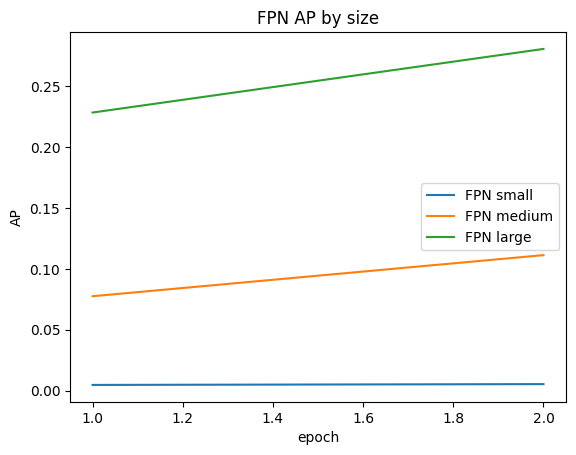

In [20]:

plt.figure(); 
plt.plot(range(1,epochs+1), res_fpn['map_s_hist'], label='FPN small')
plt.plot(range(1,epochs+1), res_fpn['map_m_hist'], label='FPN medium')
plt.plot(range(1,epochs+1), res_fpn['map_l_hist'], label='FPN large')
plt.xlabel('epoch'); plt.ylabel('AP'); plt.title('FPN AP by size'); plt.legend(); plt.show()


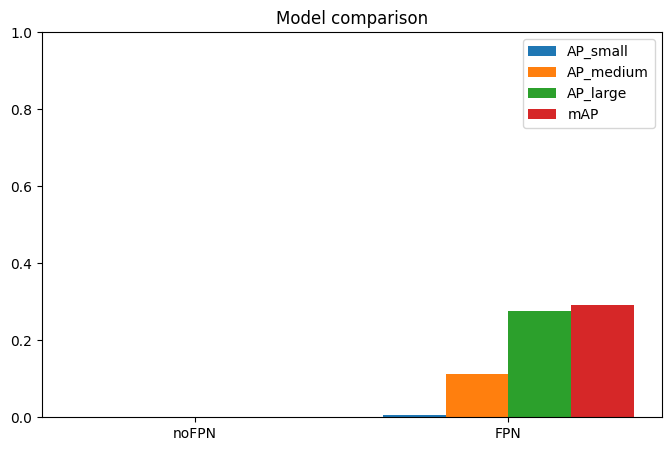

In [21]:
labels = ['noFPN','FPN']
mAPs = [res_nofpn['mAP'], res_fpn['mAP']]
mAPs_s = [res_nofpn['mAP_small'], res_fpn['mAP_small']]
mAPs_m = [res_nofpn['mAP_medium'], res_fpn['mAP_medium']]
mAPs_l = [res_nofpn['mAP_large'], res_fpn['mAP_large']]
x = np.arange(len(labels)); w = 0.2
plt.figure(figsize=(8,5))
plt.bar(x-1.5*w, mAPs_s, width=w, label='AP_small')
plt.bar(x-0.5*w, mAPs_m, width=w, label='AP_medium')
plt.bar(x+0.5*w, mAPs_l, width=w, label='AP_large')
plt.bar(x+1.5*w, mAPs, width=w, label='mAP')
plt.xticks(x, labels); plt.ylim(0,1); plt.legend(); plt.title('Model comparison'); plt.show()


In [22]:
class VOCDatasetImproved(VOCDataset):
    def __init__(self, root, year, image_set, transforms=None):
        super().__init__(root, year, image_set, transforms)
    def __getitem__(self, idx):
        img, t = self.ds[idx]
        boxes, labels, w, h = parse_voc_target(t)
        if random.random()<0.2 and boxes.numel()>0:
            sx = random.uniform(0.6,1.0); sy = random.uniform(0.6,1.0)
            x = random.uniform(0, w*(1-sx)); y = random.uniform(0, h*(1-sy))
            crop = (int(x), int(y), int(x+sx*w), int(y+sy*h))
            img = img.crop(crop)
            boxes = boxes - torch.tensor([crop[0],crop[1],crop[0],crop[1]])
            boxes[:,0::2] = boxes[:,0::2].clamp(0, crop[2]-crop[0]-1)
            boxes[:,1::2] = boxes[:,1::2].clamp(0, crop[3]-crop[1]-1)
        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx]), 'orig_size': torch.tensor([h,w])}
        if self.transforms: img, target = self.transforms(img, target)
        return img, target


In [23]:
import contextlib, torch

def _sanitize_target_inplace(target, H, W):
    boxes = target['boxes']
    if boxes.numel() == 0:
        return target
    boxes[:, 0::2] = boxes[:, 0::2].clamp(0, W - 1)
    boxes[:, 1::2] = boxes[:, 1::2].clamp(0, H - 1)
    wh = boxes[:, 2:] - boxes[:, :2]
    keep = (wh[:, 0] > 1) & (wh[:, 1] > 1)
    target['boxes'] = boxes[keep]
    target['labels'] = target['labels'][keep]
    return target

class SanitizeBoxes:
    def __call__(self, img, target):
        if isinstance(img, torch.Tensor):
            H, W = img.shape[1], img.shape[2]
        else:
            W, H = img.size
        return img, _sanitize_target_inplace(target, H, W)

train_tf = Compose([RandomHFlip(0.5), ResizeJitter(320,640), SanitizeBoxes()])
val_tf   = Compose([FixedResize(512), SanitizeBoxes()])

train_tf_impr = Compose([RandomHFlip(0.5), ResizeJitter(400,800), SanitizeBoxes()])


In [24]:
voc12_train_impr = VOCDatasetImproved(VOC_ROOT, '2012', 'train', transforms=train_tf_impr)
train_impr = voc12_train_impr
train_loader_impr = DataLoader(train_impr, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn, pin_memory=True)

frac = 0.2
seed = 42
n_imp = len(train_impr)
n_sub_imp = max(1, int(math.ceil(frac * n_imp)))
rng = np.random.default_rng(seed)
idx_imp = np.sort(rng.choice(n_imp, size=n_sub_imp, replace=False)).tolist()
train_loader_impr = DataLoader(
    train_impr,
    batch_size=4,
    sampler=SubsetRandomSampler(idx_imp),
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True,
)
print({'train_impr_subset': len(idx_imp), 'train_impr_total': n_imp})


{'train_impr_subset': 1144, 'train_impr_total': 5717}


  0%|          | 0/286 [00:10<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/286 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

{
  "mAP": 0.7192251631349296,
  "mAP_small": 0.08258796413272496,
  "mAP_medium": 0.19773215946585085,
  "mAP_large": 0.6585778251673069
}


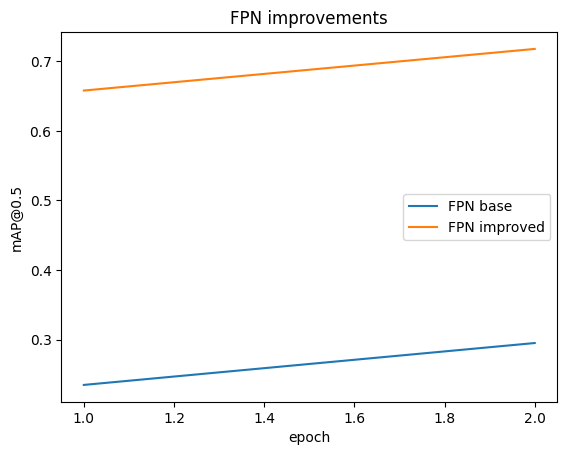

In [25]:
epochs = 2
model_fpn_impr = make_fasterrcnn_fpn(21)
res_fpn_impr = fit_with_eval(model_fpn_impr, train_loader_impr, val_loader, epochs=epochs, lr=0.005)
print(json.dumps({'mAP':res_fpn_impr['mAP'],'mAP_small':res_fpn_impr['mAP_small'],'mAP_medium':res_fpn_impr['mAP_medium'],'mAP_large':res_fpn_impr['mAP_large']}, indent=2))

plt.figure(); plt.plot(range(1,epochs+1), res_fpn['map_hist'], label='FPN base')
plt.plot(range(1,epochs+1), res_fpn_impr['map_hist'], label='FPN improved')
plt.xlabel('epoch'); plt.ylabel('mAP@0.5'); plt.title('FPN improvements'); plt.legend(); plt.show()


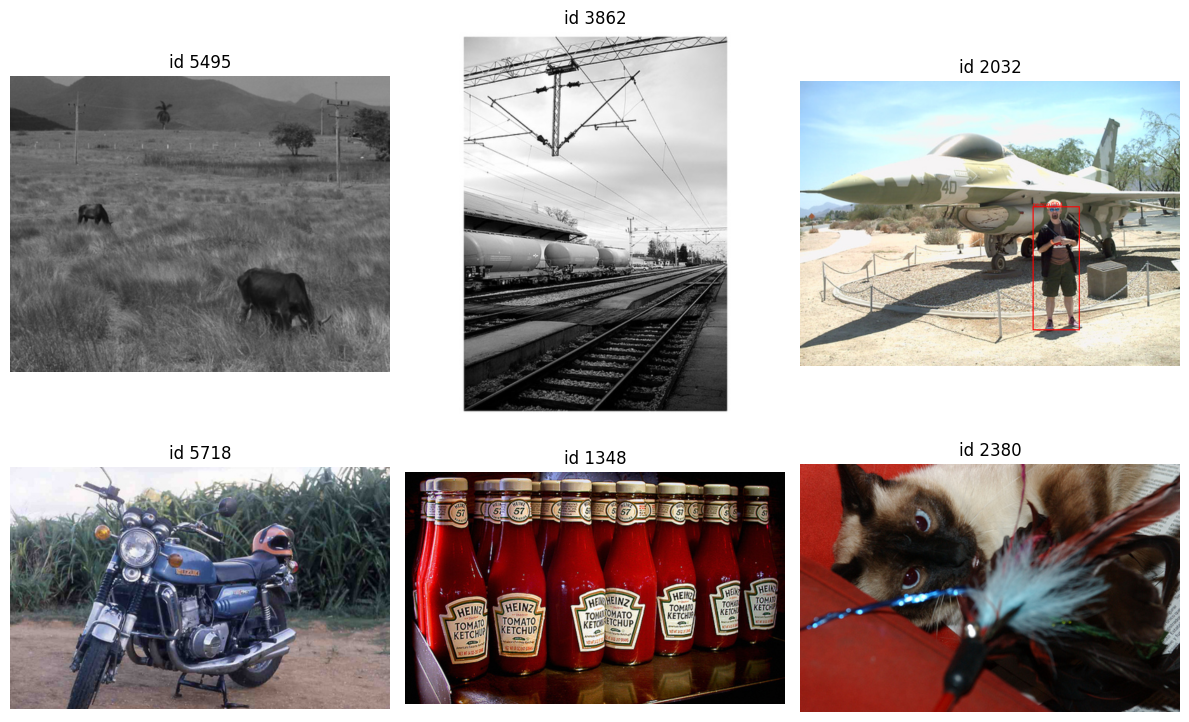

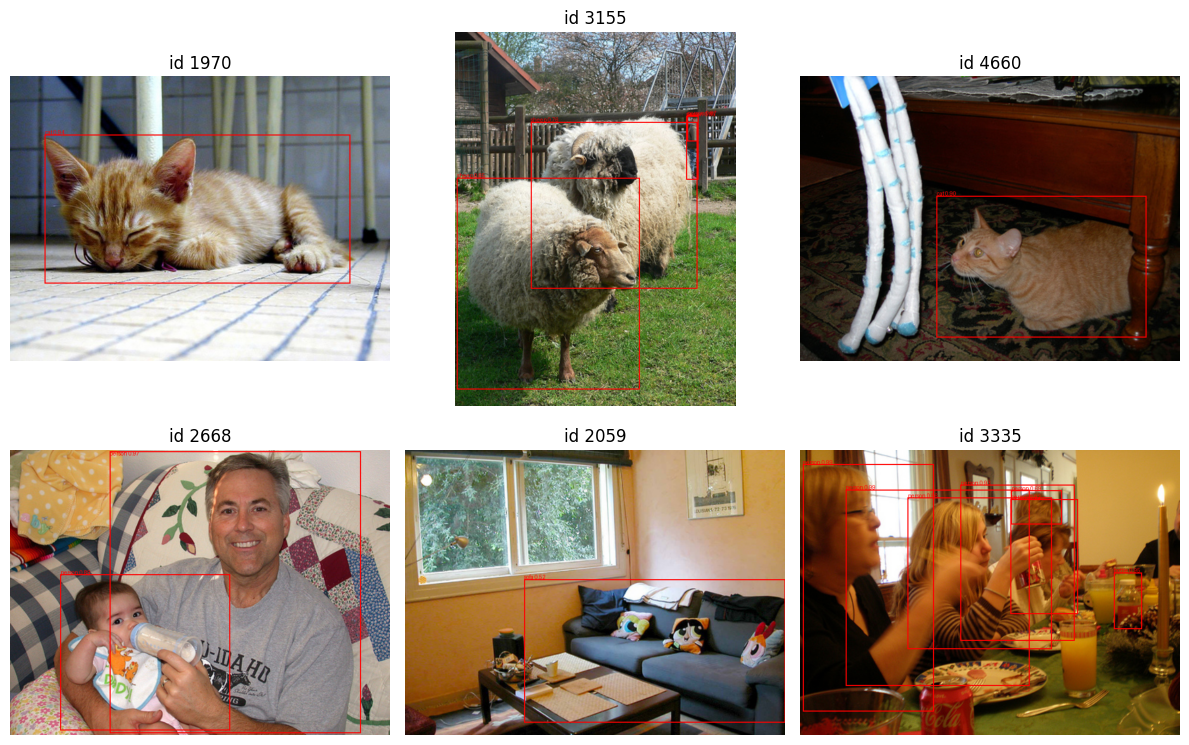

In [26]:
def show_predictions(preds, gts, loader, k=6, thr=0.5):
    ids = list(preds.keys())
    random.shuffle(ids)
    ids = ids[:k]
    imgs = []
    for imgs_batch, tgts in loader:
        for i in range(len(imgs_batch)):
            img_id = int(tgts[i]['image_id'])
            if img_id in ids: imgs.append((imgs_batch[i], img_id))
    fig = plt.figure(figsize=(12,8))
    for j, (img_t, img_id) in enumerate(imgs[:k]):
        ax = plt.subplot(2,3,j+1)
        p = preds[img_id]
        m = p['scores']>=thr
        img = draw_boxes(img_t, p['boxes'][m].numpy(), p['labels'][m].numpy(), p['scores'][m].numpy())
        ax.imshow(img); ax.set_title(f'id {img_id}'); ax.axis('off')
    plt.tight_layout(); plt.show()

gts = collect_gts(val_loader)
show_predictions(res_fpn['preds'], gts, val_loader, 6, 0.5)
show_predictions(res_fpn_impr['preds'], gts, val_loader, 6, 0.5)


In [27]:
summary = {
    'noFPN': {'mAP':res_nofpn['mAP'],'AP_small':res_nofpn['mAP_small'],'AP_medium':res_nofpn['mAP_medium'],'AP_large':res_nofpn['mAP_large']},
    'FPN': {'mAP':res_fpn['mAP'],'AP_small':res_fpn['mAP_small'],'AP_medium':res_fpn['mAP_medium'],'AP_large':res_fpn['mAP_large']},
    'FPN_improved': {'mAP':res_fpn_impr['mAP'],'AP_small':res_fpn_impr['mAP_small'],'AP_medium':res_fpn_impr['mAP_medium'],'AP_large':res_fpn_impr['mAP_large']}
}
print(json.dumps(summary, indent=2))
best = max(summary.items(), key=lambda kv: kv[1]['mAP'])
print(f"Best overall mAP: {best[0]} {best[1]['mAP']:.3f}")
best_s = max(summary.items(), key=lambda kv: kv[1]['AP_small'])
print(f"Best AP_small: {best_s[0]} {best_s[1]['AP_small']:.3f}")
if summary['FPN']['mAP']>summary['noFPN']['mAP']:
    print("Conclusion: FPN improves overall mAP over non-FPN baseline.")
else:
    print("Conclusion: FPN did not improve overall mAP in this run.")
if summary['FPN']['AP_small']>summary['noFPN']['AP_small']:
    print("Conclusion: FPN improves small-object AP compared to non-FPN.")
else:
    print("Conclusion: FPN did not improve small-object AP in this run.")
if summary['FPN_improved']['mAP']>summary['FPN']['mAP']:
    print("Conclusion: Multi-scale and stronger augmentation improved FPN.")
else:
    print("Conclusion: Multi-scale and stronger augmentation did not improve FPN in this run.")


{
  "noFPN": {
    "mAP": 0.00023474178403755868,
    "AP_small": 0.0,
    "AP_medium": 0.0,
    "AP_large": 0.0003225806451612903
  },
  "FPN": {
    "mAP": 0.2925865503149404,
    "AP_small": 0.005266451971393597,
    "AP_medium": 0.11257572086735503,
    "AP_large": 0.2770585833684396
  },
  "FPN_improved": {
    "mAP": 0.7192251631349296,
    "AP_small": 0.08258796413272496,
    "AP_medium": 0.19773215946585085,
    "AP_large": 0.6585778251673069
  }
}
Best overall mAP: FPN_improved 0.719
Best AP_small: FPN_improved 0.083
Conclusion: FPN improves overall mAP over non-FPN baseline.
Conclusion: FPN improves small-object AP compared to non-FPN.
Conclusion: Multi-scale and stronger augmentation improved FPN.
